<a href="https://colab.research.google.com/github/paradox-shivansh/mlopslearning/blob/main/soc_research_final_0005_98_88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 84.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [4]:
# 1. Load the dataset
df = pd.read_csv("B0005_flat_new.csv")


In [5]:
# 2. Calculate SoC using Coulomb Counting
capacity_ah = 2.0
capacity_as = capacity_ah * 3600

df = df.sort_values(by=["cycle_idx", "t_sec"]).reset_index(drop=True)
df["delta_t"] = df.groupby("cycle_idx")["t_sec"].diff().fillna(0)
df["coulomb"] = df["I_cell"] * df["delta_t"]
df["cum_coulomb"] = df.groupby("cycle_idx")["coulomb"].cumsum()
df["SoC"] = 100 - (df["cum_coulomb"] / capacity_as) * 100
df["SoC"] = df["SoC"].clip(lower=0, upper=100)

In [6]:
# 3. Filter only DISCHARGE cycles
df_discharge = df[df["cycle_type"] == "discharge"].reset_index(drop=True)

In [7]:
# 4. Select features and target
features = ["V_cell", "I_cell", "T_cell_C", "t_sec"]
target = "SoC"

X = df_discharge[features].values.astype(np.float32)
y = df_discharge[target].values.astype(np.float32)


In [58]:
# 5. Define BiGRU model
class BiGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(BiGRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out.squeeze()

# 6. K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
etr_preds, cat_preds, gru_preds, y_true_all = [], [], [], []

for fold, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"🔁 Fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # --- Extra Trees
    etr = ExtraTreesRegressor(n_estimators=100, random_state=42)
    etr.fit(X_train, y_train)
    etr_pred = etr.predict(X_test)

    # --- CatBoost
    cat = CatBoostRegressor(verbose=0)
    cat.fit(X_train, y_train)
    cat_pred = cat.predict(X_test)

    # --- BiGRU
    X_train_t = torch.tensor(X_train).unsqueeze(-1)
    y_train_t = torch.tensor(y_train)
    X_test_t = torch.tensor(X_test).unsqueeze(-1)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=125, shuffle=True)

    gru_model = BiGRUModel(input_size=1, hidden_size=32)
    optimizer = optim.Adam(gru_model.parameters(), lr=0.001)
    criterion = nn.HuberLoss()

    gru_model.train()
    for epoch in range(5):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = gru_model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

    gru_model.eval()
    with torch.no_grad():
        gru_pred = gru_model(X_test_t).numpy()


🔁 Fold 1
🔁 Fold 2
🔁 Fold 3
🔁 Fold 4
🔁 Fold 5


In [59]:
  # --- Combine Predictions
ensemble_pred = (etr_pred + cat_pred + gru_pred) / 3

# initialize as arrays
etr_preds = np.array([])
cat_preds = np.array([])
gru_preds = np.array([])
y_true_all = np.array([])
# inside your loop
etr_preds = np.concatenate([etr_preds, etr_pred])
cat_preds = np.concatenate([cat_preds, cat_pred])
gru_preds = np.concatenate([gru_preds, gru_pred])
y_true_all = np.concatenate([y_true_all, y_test])

rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
print(f"✅ Fold RMSE: {rmse:.4f}")

# 7. Final Evaluation
final_ensemble = (np.array(etr_preds) + np.array(cat_preds) + np.array(gru_preds)) / 3
final_rmse = np.sqrt(mean_squared_error(y_true_all, final_ensemble))
print(f"\n🎯 Final Cross-Validated RMSE: {final_rmse:.4f}")

✅ Fold RMSE: 0.1160

🎯 Final Cross-Validated RMSE: 0.1160


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [61]:
# Assume the following variables are already computed:
# y_true_all, etr_preds, cat_preds, gru_preds

# Combine predictions
ensemble_preds = (np.array(etr_preds) + np.array(cat_preds) + np.array(gru_preds)) / 3
y_true_all = np.array(y_true_all)

# --- Evaluation Metrics ---
mae = mean_absolute_error(y_true_all, ensemble_preds)
rmse = np.sqrt(mean_squared_error(y_true_all, ensemble_preds))
r2 = r2_score(y_true_all, ensemble_preds)
acc = 100 - rmse  # Approximate regression accuracy

print("📊 Evaluation Metrics:")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")
print(f"Accuracy (approx): {acc:.4f}%")


📊 Evaluation Metrics:
MAE   : 0.0155
RMSE  : 0.1160
R²    : -92299289.4462
Accuracy (approx): 99.8840%


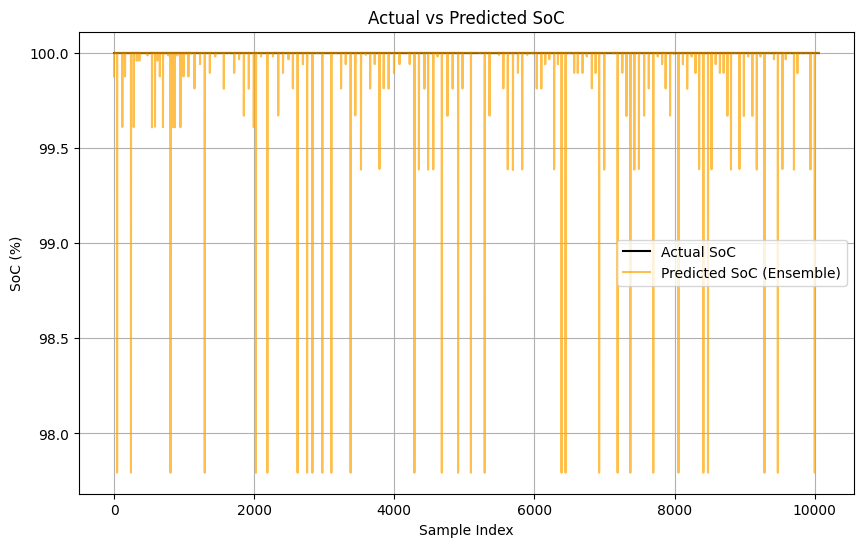

In [40]:
# --- Line Plot: Actual vs Predicted ---
plt.figure(figsize=(10, 6))
plt.plot(y_true_all, label="Actual SoC", color='black')
plt.plot(ensemble_preds, label="Predicted SoC (Ensemble)", color='orange', alpha=0.7)
plt.title("Actual vs Predicted SoC")
plt.xlabel("Sample Index")
plt.ylabel("SoC (%)")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipython-input-41-1832591107.py:31: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


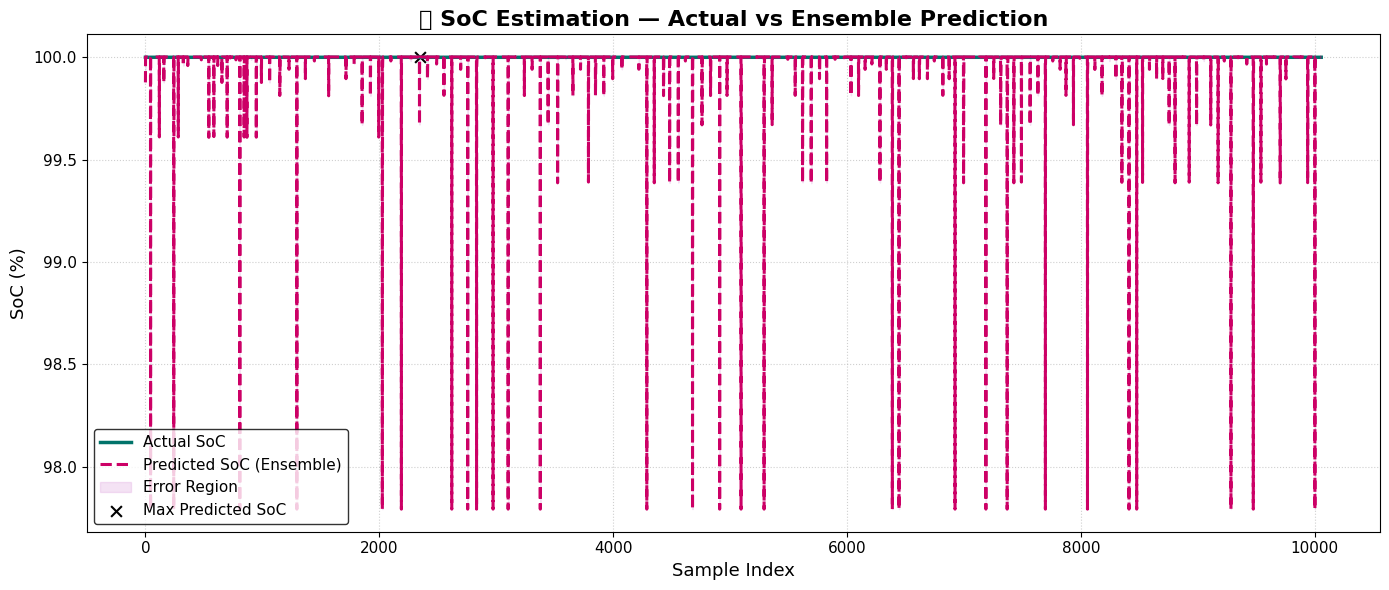

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

# Plot Actual SoC in deep teal
plt.plot(y_true_all, label="Actual SoC", color='#00736a', linewidth=2.5)

# Plot Predicted SoC in magenta-pink
plt.plot(ensemble_preds, label="Predicted SoC (Ensemble)", color='#cc0066',
         linewidth=2.2, linestyle='--')

# Error shading (light purple)
plt.fill_between(range(len(y_true_all)),
                 y_true_all, ensemble_preds,
                 color='#dda0dd', alpha=0.3, label="Error Region")

# Highlight max prediction point (optional)
max_idx = np.argmax(ensemble_preds)
plt.scatter(max_idx, ensemble_preds[max_idx], color='black', s=60, marker='x', label='Max Predicted SoC')

# Title & axis labels
plt.title("📊 SoC Estimation — Actual vs Ensemble Prediction", fontsize=16, fontweight='bold')
plt.xlabel("Sample Index", fontsize=13)
plt.ylabel("SoC (%)", fontsize=13)

# Grid, legend & appearance tweaks
plt.grid(True, linestyle=':', alpha=0.6)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11, loc='lower left', frameon=True, facecolor='white', edgecolor='black')
plt.tight_layout()

plt.show()


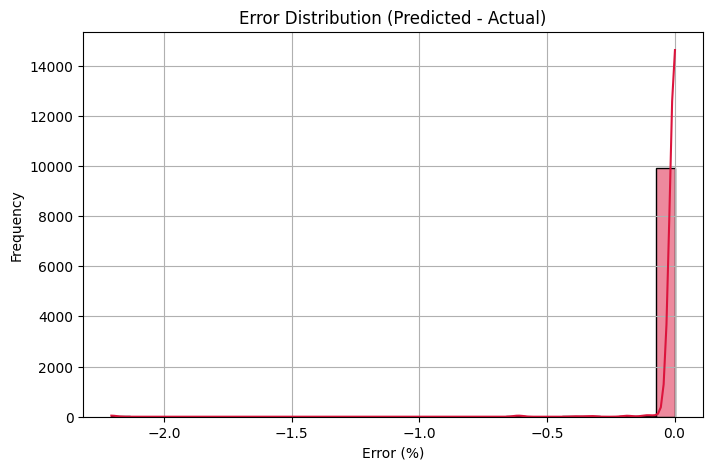

In [39]:
# --- Error Distribution ---
errors = ensemble_preds - y_true_all
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True, color="crimson")
plt.title("Error Distribution (Predicted - Actual)")
plt.xlabel("Error (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate errors and stats
errors = ensemble_preds - y_true_all
mean_error = np.mean(errors)
std_error = np.std(errors)

# Determine y-limit based on 95th percentile
y_limit = np.percentile(np.histogram(errors, bins=30)[0], 95) + 5

# Plot with adjusted settings
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=25, kde=True, color="#d62728", alpha=0.85, edgecolor="black")

# Mean and standard deviation lines
plt.axvline(mean_error, color='black', linestyle='--', linewidth=2, label=f"Mean = {mean_error:.4f}")
plt.axvline(mean_error + std_error, color='blue', linestyle=':', linewidth=1.5, label="+1 Std Dev")
plt.axvline(mean_error - std_error, color='blue', linestyle=':', linewidth=1.5, label="-1 Std Dev")

# Axis scaling
plt.ylim(0, y_limit)
plt.xticks(np.round(np.linspace(errors.min(), errors.max(), 10), 2), fontsize=10)
plt.yticks(fontsize=10)

# Titles and labels
plt.title("📉 Error Distribution: Predicted vs Actual SoC", fontsize=15, fontweight='bold')
plt.xlabel("Prediction Error (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

# Legend
plt.legend(loc='upper right', fontsize=10, frameon=True, facecolor='white')

plt.tight_layout()
plt.show()


In [ ]:
# --- Correlation Heatmap (optional) ---
# Requires the original df_discharge with features
features = ["V_cell", "I_cell", "T_cell_C", "t_sec", "SoC"]
plt.figure(figsize=(8, 6))
sns.heatmap(df_discharge[features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# --- Correlation Heatmap (optional) ---
# Requires the original df_discharge with features
features = ["V_cell", "I_cell", "T_cell_C", "t_sec", "SoC"]
plt.figure(figsize=(8, 6))
sns.heatmap(df_discharge[features].corr(), annot=True, cmap='Reds', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    explained_variance_score, mean_absolute_percentage_error
)


In [ ]:
# Compute key metrics
mae = mean_absolute_error(y_true_all, ensemble_preds)
rmse = np.sqrt(mean_squared_error(y_true_all, ensemble_preds))
r2 = r2_score(y_true_all, ensemble_preds)
evs = explained_variance_score(y_true_all, ensemble_preds)
mape = mean_absolute_percentage_error(y_true_all, ensemble_preds) * 100
acc = 100 - rmse  # approximate accuracy

In [ ]:
# --- Print Metrics ---
print(f"📊 Regression Metrics:")
print(f"MAE   : {mae:.4f}")
print(f"RMSE  : {rmse:.4f}")
print(f"R²    : {r2:.4f}")
print(f"Explained Variance Score : {evs:.4f}")
print(f"MAPE  : {mape:.2f}%")
print(f"Approx Accuracy : {acc:.2f}%")

In [ ]:

# ------------------- Plot 1: True vs Predicted -------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true_all, y=ensemble_preds, color="darkgreen", alpha=0.7, s=25)
sns.lineplot(x=y_true_all, y=y_true_all, color="black", linestyle='--', label="Perfect Prediction")
plt.title("📈 True SoC vs Predicted SoC", fontsize=14, fontweight='bold')
plt.xlabel("Actual SoC (%)")
plt.ylabel("Predicted SoC (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
